In [1]:
import torch
import time
import os
import numpy as np
from models.networks import NGP
from models.rendering import render
from metrics import psnr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import dataset_dict
from datasets.ray_utils import get_ray_directions, get_rays
from utils import load_ckpt
from train import depth2img
import imageio

dataset_name = 'mgtv'
scene = 'F1_06'
take = '000000'
dataset = dataset_dict[dataset_name](
    '/home/ubuntu/hdd/data/mgtv', scene=scene, take=take,
    split='test', downsample=1.0
)

Loading 0 test images ...


0it [00:00, ?it/s]


In [2]:
model = NGP(scale=0.5).cuda()
load_ckpt(model, f'ckpts/{dataset_name}/{scene}/{take}/epoch=4_slim.ckpt')

GridEncoding: Nmin=16 b=1.31951 F=2 T=2^19 L=16


In [3]:
with open('/home/ubuntu/hdd/data/mgtv/evaluation_code/val_rect.txt', 'r') as f:
    lines = f.readlines()
    
crop_dict = {}
for line in lines:
    filename, x, y, w, h = line.split()
    scene_, take_, filename_ = filename.split('/')
    if scene_==scene and take_==take[:6]:
        cam = int(filename_[9:11])-1
        crop_dict[cam] = (int(x), int(y), int(w), int(h))

In [20]:
psnrs = []; ts = []
os.makedirs(f'results/{dataset_name}/{scene}/{take}', exist_ok=True)

for cam in [2]:#tqdm(range(92)):
    t = time.time()

    directions = get_ray_directions(dataset.Hs[cam], dataset.Ws[cam], dataset.Ks[cam], flatten=False)
#     if cam in crop_dict:
#         x, y, w, h = crop_dict[cam]
#         directions = directions[y:y+h, x:x+w]
#     else:
#         continue
    w = dataset.Ws[cam]
    h = dataset.Hs[cam]
    directions = directions.reshape(-1, 3)
    rays_o, rays_d = get_rays(directions.cuda(), dataset.poses[cam].cuda())
    
    results = render(model, rays_o, rays_d, **{'test_time': True})
    torch.cuda.synchronize()
    ts += [time.time()-t]

#     pred = results['rgb'].reshape(h, w, 3).cpu().numpy()
#     pred = (pred*255).astype(np.uint8)
#     imageio.imwrite(f'results/{dataset_name}/{scene}/{take}/image.cam{cam+1:02d}_{take}.jpg', pred)
    
    torch.cuda.empty_cache()

print(f'mean time: {np.mean(ts):.4f} s, FPS: {1/np.mean(ts):.2f}')
print(f'mean samples per ray: {results["total_samples"]/len(rays_d):.2f}')

mean time: 0.2166 s, FPS: 4.62
mean samples per ray: 34.19


In [16]:
from kornia import create_meshgrid
from einops import rearrange

ref = 2 # what we want
src = cam # what we have

x = torch.eye(4)

c2w = torch.eye(4)
c2w[:3] = dataset.poses[src]
w2c = torch.inverse(c2w)

x[:3, :3] = dataset.Ks[src]
src_proj = x @ w2c

c2w = torch.eye(4)
c2w[:3] = dataset.poses[ref]
w2c = torch.inverse(c2w)

x[:3, :3] = dataset.Ks[ref]
ref_proj_inv = torch.inverse(x @ w2c)

proj_mat = (src_proj @ ref_proj_inv)[:3].cuda() # (3, 4)


R = proj_mat[None, :, :3] # (1, 3, 3)
T = proj_mat[None, :, 3:] # (1, 3, 1)
ref_grid = create_meshgrid(h, w, False, device='cuda') # (1, H, W, 2)
ref_grid = rearrange(ref_grid, '1 h w c -> 1 c (h w)') # (1, 2, H*W)
ref_grid = torch.cat((ref_grid, torch.ones_like(ref_grid[:, :1])), 1) # (1, 3, H*W)
ref_grid_d = ref_grid * results['depth'].reshape(1, 1, h*w)
src_grid_d = R @ ref_grid_d + T # (1, 3, H*W)

src_grid = src_grid_d[:, :2] / src_grid_d[:, 2:] # divide by depth (1, 2, H*W)
src_grid[:, 0] = src_grid[:, 0]/((w-1)/2) - 1 # scale to -1~1
src_grid[:, 1] = src_grid[:, 1]/((h-1)/2) - 1 # scale to -1~1
src_grid = rearrange(src_grid, '1 c (h w) -> 1 h w c', h=h, w=w)

img = imageio.imread(f'/home/ubuntu/hdd/data/mgtv/val/F1_06/000000/image.cam{src+1:02d}_000000.png').astype(np.float32)/255.0
img[..., :3] = img[..., :3]*img[..., -1:]
src_img = torch.cuda.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)

In [17]:
out = torch.nn.functional.grid_sample(src_img, src_grid, 
                                mode='bilinear', padding_mode='zeros', align_corners=True)

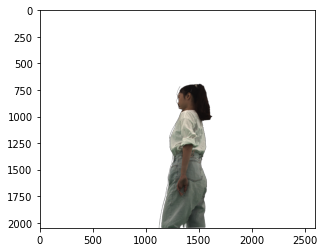

In [18]:
plt.imshow(out[0].permute(1, 2, 0).cpu().numpy())

In [21]:
x, y, w_, h_ = crop_dict[ref]
pred = out[0].permute(1, 2, 0).cpu().numpy()[y:y+h_, x:x+w_, :3]
pred = (pred*255).astype(np.uint8)
imageio.imwrite(f'results/{dataset_name}/{scene}/{take}/image.cam{ref+1:02d}_{take}.jpg', pred)

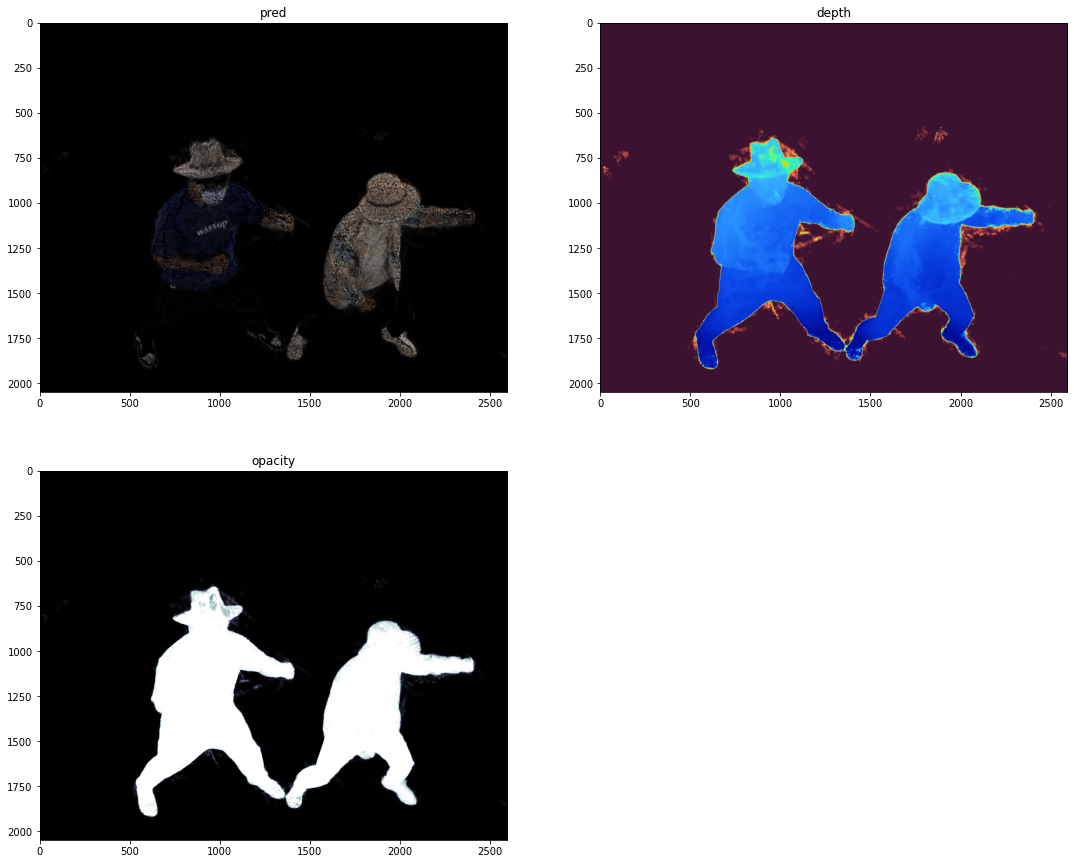

In [11]:
plt.subplots(figsize=(15, 12))
plt.tight_layout()
plt.subplot(221)
plt.title('pred')
pred = results['rgb'].reshape(h, w, 3).cpu().numpy()
plt.imshow(pred)
plt.subplot(222)
plt.title('depth')
depth = results['depth'].reshape(h, w).cpu().numpy()
depth_ = depth2img(depth)
plt.imshow(depth_)
plt.subplot(223)
plt.title('opacity')
plt.imshow(results['opacity'].reshape(h, w).cpu().numpy(), 'bone')
plt.show()

In [13]:
from kornia.utils.grid import create_meshgrid3d
import vren
import cc3d

G = model.grid_size

xyz = create_meshgrid3d(G, G, G, False, dtype=torch.int32).reshape(-1, 3)
indices = vren.morton3D(xyz.cuda()).long().cpu().numpy()

_density_bitfield = model.density_bitfield

density_bitfield = torch.zeros(model.cascades*G**3//8, 8, dtype=torch.bool)
for i in range(8):
    density_bitfield[:, i] = _density_bitfield & torch.tensor([2**i], device='cuda')
density_bitfield = density_bitfield.reshape(model.cascades, G**3).cpu().numpy()

largest_connected_components = \
    cc3d.largest_k(density_bitfield[0, indices].reshape(G, G, G),
                   k=1, connectivity=6)
new_density_grid = torch.zeros(model.cascades, G**3, device='cuda')
new_density_grid[0, indices] = \
    torch.cuda.FloatTensor(largest_connected_components.reshape(model.cascades, -1).astype(np.float32))

# update
vren.packbits(new_density_grid, 0.5, model.density_bitfield)

_density_bitfield = model.density_bitfield
density_bitfield = torch.zeros(model.cascades*G**3//8, 8, dtype=torch.bool)
for i in range(8):
    density_bitfield[:, i] = _density_bitfield & torch.tensor([2**i], device='cuda')
density_bitfield = density_bitfield.reshape(model.cascades, G**3).cpu()

In [ ]:
from datasets.ray_utils import get_rays
import plotly.graph_objects as go
from collections import defaultdict
import cc3d

fig = go.Figure()

# cameras
# TODO: add axes
K = np.array([[800, 0, 400], [0, 800, 400], [0, 0, 1]])
img_wh = (800, 800)
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
u = torch.FloatTensor([0, img_wh[0]-1, img_wh[0]-1, 0])
v = torch.FloatTensor([0, 0, img_wh[1]-1, img_wh[1]-1])
ds = torch.stack([(u-cx+0.5)/fx, (v-cy+0.5)/fy, torch.ones_like(u)], -1)

xlines = []; ylines = []; zlines = []
for ip in range(len(dataset.poses)):
    o, d = get_rays(ds, torch.FloatTensor(dataset.poses[ip]))
    o = o.numpy(); d = d.numpy()/10
    od = o+d
    xlines += [od[0, 0], od[1, 0], od[2, 0], od[3, 0], od[0, 0], None]
    ylines += [od[0, 1], od[1, 1], od[2, 1], od[3, 1], od[0, 1], None]
    zlines += [od[0, 2], od[1, 2], od[2, 2], od[3, 2], od[0, 2], None]
    for i in range(4):
        xlines += [o[i, 0], od[i, 0], None]
        ylines += [o[i, 1], od[i, 1], None]
        zlines += [o[i, 2], od[i, 2], None]
fig.add_trace(
    go.Scatter3d(
        x=xlines,
        y=ylines,
        z=zlines,
        mode='lines',
        name='cameras',
        marker=dict(size=1, color='black')
    )
)

# # RAYS
# try:
#     xlines = []; ylines = []; zlines = []
#     o = rays_o.cpu().numpy()
#     d = rays_d.cpu().numpy()
#     for i in range(len(o)):
#         xlines += [o[i, 0], o[i, 0]+3*d[i, 0], None]
#         ylines += [o[i, 1], o[i, 1]+3*d[i, 1], None]
#         zlines += [o[i, 2], o[i, 2]+3*d[i, 2], None]

#     fig.add_trace(
#         go.Scatter3d(
#             x=xlines,
#             y=ylines,
#             z=zlines,
#             mode='lines',
#             name='rays',
#             marker=dict(size=1, color='green')
#         )
#     )
# except: pass

for ca in range(model.cascades):
    s = min(2**(ca-1), model.scale)
    xlines = [s, s, s, s, s, None, -s, -s, -s, -s, -s, None]
    ylines = [-s, -s, s, s, -s, None, -s, -s, s, s, -s, None]
    zlines = [s, -s, -s, s, s, None, s, -s, -s, s, s, None]
    xlines += [s, -s, None, s, -s, None, s, -s, None, s, -s, None]
    ylines += [-s, -s, None, -s, -s, None, s, s, None, s, s, None]
    zlines += [s, s, None, -s, -s, None, -s, -s, None, s, s, None]
    fig.add_trace(
        go.Scatter3d(
            x=xlines,
            y=ylines,
            z=zlines,
            mode='lines',
            name=f'bbox {ca}',
            marker=dict(size=1, color='orange')
        )
    )

try:
    m = defaultdict(list)
    cube_colors = ['lightgray', 'lightcyan', 'magenta']
    for ca in range(model.cascades):
        if ca>0: break
        s = min(2**(ca-1), model.scale)
        xyz_ = xyz[density_bitfield[ca, indices]]
        if len(xyz_)==0: continue
        for i in tqdm(range(len(xyz_))):
            hs = s/model.grid_size
            c = (xyz_[i].numpy()/(model.grid_size-1)*2-1)*(s-hs)
            m['x'] += [(np.array([0, 0, 1, 1, 0, 0, 1, 1])-0.5)*2*hs+c[0]]
            m['y'] += [(np.array([0, 1, 1, 0, 0, 1, 1, 0])-0.5)*2*hs+c[1]]
            m['z'] += [(np.array([0, 0, 0, 0, 1, 1, 1, 1])-0.5)*2*hs+c[2]]
            m['i'] += [np.array([7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2])+len(m['i'])*8]
            m['j'] += [np.array([3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3])+len(m['j'])*8]
            m['k'] += [np.array([0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6])+len(m['k'])*8]
        fig.add_trace(
            go.Mesh3d(
                x=np.concatenate(m['x']),
                y=np.concatenate(m['y']),
                z=np.concatenate(m['z']),
                i=np.concatenate(m['i']),
                j=np.concatenate(m['j']),
                k=np.concatenate(m['k']),
                color=cube_colors[ca],
                name=f'occupied cells {ca}',
                showlegend=True,
                opacity=0.4**(ca+1)
            )
        )
except: pass

layout = go.Layout(scene=dict(aspectmode='data'), dragmode='orbit')
fig.update_layout(layout)

fig.show()